In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd
#import matplotlib.pyplot as plt 
#import seaborn as sns 
from torch.nn import Conv1d, MaxPool1d, Linear, Dropout, BCEWithLogitsLoss
from sklearn.metrics import roc_auc_score, average_precision_score

import torch
import networkx as nx
import  torch_geometric
import numpy as np
import dill as pickle

from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

# Test Things

### k_hop_subgraph

In [81]:
edge_index = torch.tensor([[0, 1, 2, 3, 4, 5],[2, 2, 4, 4, 6, 6]])
print(f'edge_index: {edge_index}')

edge_index: tensor([[0, 1, 2, 3, 4, 5],
        [2, 2, 4, 4, 6, 6]])


subset: tensor([0, 1, 2, 3, 4])
edge_index: tensor([[0, 1, 2, 3],
        [2, 2, 4, 4]])
mapping: tensor([4])
edge_mask: tensor([ True,  True,  True,  True, False, False])
subset[mapping]: tensor([4])


c:\Users\morit\Documents\Python Scripts\me\lib\site-packages\torch_geometric\data\storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


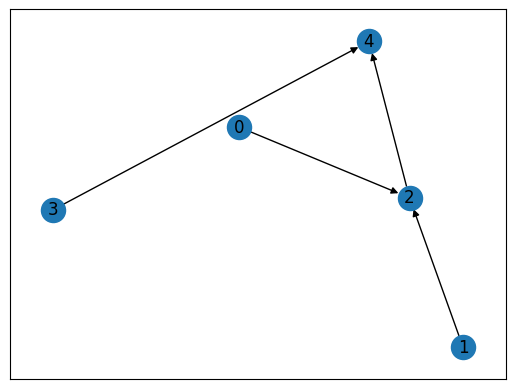

In [82]:
# Center node 6, 2-hops
subset, edge_index, mapping, edge_mask = torch_geometric.utils.k_hop_subgraph( 
                                node_idx = 4, 
                                num_hops = 2, 
                                edge_index = edge_index,
                                relabel_nodes=False)

print(f'subset: {subset}')
print(f'edge_index: {edge_index}')
print(f'mapping: {mapping}')
print(f'edge_mask: {edge_mask}')
print(f'subset[mapping]: {subset[mapping]}')

t = Data(edge_index=edge_index)
g = torch_geometric.utils.to_networkx(t)

nx.draw_networkx(g)


In [66]:
print(f'data: {data}')

print(f'data["isbn" , "rev_review", "user"].edge_index: {data["isbn" , "rev_review", "user"].edge_index}')

subset, edge_index, mapping, edge_mask = torch_geometric.utils.k_hop_subgraph( 
                                node_idx = 3, 
                                num_hops = 1, 
                                edge_index = data["isbn" , "rev_review", "user"].edge_index,
                                relabel_nodes=True,
                                )
print()
print(f'subset: {subset}')
print(f'edge_index: {edge_index}')
print(f'mapping: {mapping}')
print(f'edge_mask: {edge_mask}')
print(f'subset[mapping]: {subset[mapping]}')


data: HeteroData(
  user={ node_id=[47074] },
  isbn={
    node_id=[98417],
    x=[98417, 8751]
  },
  (user, review, isbn)={ edge_index=[2, 223807] },
  (isbn, rev_review, user)={ edge_index=[2, 223807] }
)

subset: tensor([1, 3])
edge_index: tensor([[0],
        [1]])
mapping: tensor([1])
edge_mask: tensor([False, False, False,  ..., False, False, False])
subset[mapping]: tensor([3])


### create subgrah for the isbns

In [23]:
#isbn_l = [0]
from torch_geometric.data import Data

In [24]:
def build_neighbors_for_isbn(isbn_index):
    #print(f'isbn: {isbn_index}')
    subset, edge_index_user_Isbn, mapping, edge_mask = torch_geometric.utils.k_hop_subgraph(
        node_idx = isbn_index,
        num_hops = 1,
        edge_index = data["user", "review", "isbn"].edge_index
                                                                                )

    choose_5_user_of_isbn = np.random.choice(edge_index_user_Isbn[0],size =5, replace=False)

    safe = {}
    for user in choose_5_user_of_isbn:
        #print(f'user: {user}')
        subset, edge_index_isbn_user, mapping, edge_mask = torch_geometric.utils.k_hop_subgraph( 
                                    node_idx = int(user), 
                                    num_hops = 1, 
                                    edge_index = data["isbn" , "rev_review", "user"].edge_index,
                                    
                                    )
        
        #print(f'edge_index_isbn_user {edge_index_isbn_user}')
        #print(f'len(edge_index_isbn_user[0]) {len(edge_index_isbn_user[0])}')
        #print(f'edge_index_isbn_user[0] {edge_index_isbn_user[0]}')
        if len(edge_index_isbn_user[0]) >= 5:
            choose_5_isbn_of_user = np.random.choice(edge_index_isbn_user[0],size =5, replace=False)
        else:
            choose_5_isbn_of_user = np.random.choice(edge_index_isbn_user[0],size =len(edge_index_isbn_user[0]), replace=False)
        safe[user] = choose_5_isbn_of_user
        
    #print()
    #print(f'safe_ {safe}')
    return safe


def create_tensor_user_isbn(output_dict):
    output_array = np.array([[],[]])
    # print(f'output_array: {output_array }')
    for k,v in output_dict.items():
    
        value_size = len(v)
        array_index = np.full(value_size, k)
        # print(f'array_index {array_index}')
        
        connect_array = np.vstack((array_index,v))
#  '      print(f'connect_array {connect_array}')
#         print()'
        output_array = np.hstack((output_array,connect_array))
    #print(f'create_tensor_user_isbn : {output_array}')
    return output_array

def create_tensor_isbn_user(output_dict, index_in):
    key_size = len(output_dict.keys())
    array_index = np.full(key_size, index_in)
    array_users = np.array(list(output_dict.keys()))
    connect_array = np.vstack((array_index,array_users))
    return connect_array

def get_isbn_x(isbn_node_id):
    x_tensor = np.zeros((len(isbn_node_id), 8751))
    for node_i , node in enumerate(isbn_node_id) :
        node_t = torch_isbn[node]
        x_tensor[node_i] = node_t
        

    return torch.tensor(x_tensor)

In [25]:
# index_in = 0
# output_dict = build_neighbors_for_isbn(index_in)
# #create_tensor_isbn_user(output_dict, index_in)
# user_to_isbn = create_tensor_user_isbn(output_dict)
# isbn_to_user = create_tensor_isbn_user(output_dict, index_in)

# isbn_to_user[[0,1],:] = isbn_to_user[[1,0],:] 

# b = np.hstack((isbn_to_user ,user_to_isbn))
# edge_index_user_to_isbn_new = torch.tensor(b).type(torch.int64)

# user_node_id = torch.tensor(list(output_dict.keys()))
# isbn_node_id = torch.tensor(list(set(edge_index_user_to_isbn_new[1].tolist())))
# isbn_x = get_isbn_x(isbn_node_id)
# edge_index_user_isbn  = edge_index_user_to_isbn_new


def build_data_for_isbn_ls(isbn_ls):
    data_dict = {}
    for isbn_in in isbn_ls:
        index_in = isbn_in
        output_dict = build_neighbors_for_isbn(index_in)
        #create_tensor_isbn_user(output_dict, index_in)
        user_to_isbn = create_tensor_user_isbn(output_dict)
        isbn_to_user = create_tensor_isbn_user(output_dict, index_in)

        isbn_to_user[[0,1],:] = isbn_to_user[[1,0],:] 

        b = np.hstack((isbn_to_user ,user_to_isbn))
        edge_index_user_to_isbn_new = torch.tensor(b).type(torch.int64)

        #user_node_id = torch.tensor(list(output_dict.keys()))
        #isbn_node_id = torch.tensor(list(set(edge_index_user_to_isbn_new[1].tolist())))
        #isbn_x = get_isbn_x(isbn_node_id)
        edge_index_user_isbn_isbn_in  = edge_index_user_to_isbn_new
        data_dict[isbn_in] = edge_index_user_isbn_isbn_in
    #print(list(data_dict.values()))
    number = 0
    
    for k,v in data_dict.items():
        if number == 0:
            t = v
        else:
            t = torch.hstack((t,v))
        number += 1
        
    user_node_id = list(set(t[0].tolist()))
    isbn_node_id = list(set(t[1].tolist()))
    isbn_x = get_isbn_x(isbn_node_id)
    return t,user_node_id,isbn_node_id, isbn_x, data_dict

In [361]:
edge_index_user_to_isbn_new,user_node_id,isbn_node_id,isbn_x, data_dict = build_data_for_isbn_ls([0,1,2])

print(user_node_id)
print(isbn_node_id)

print('=' *10)
data_new = HeteroData()

data_new["user"].node_id = user_node_id
data_new["isbn"].node_id =isbn_node_id
data_new["isbn"].x = isbn_x
data_new["user", "review", "isbn"].edge_index  = edge_index_user_to_isbn_new
data_new = T.ToUndirected()(data_new)
print(data_new)

[0, 5120, 31873, 1315, 1830, 10535, 2266, 6735, 35540, 46197, 42490, 25565]
[0, 1, 2, 5640, 265, 77196, 9231, 32788, 23578, 9501, 1312, 8227, 4394, 30379, 2220, 12204, 8236, 14383, 683, 4397, 4399, 6452, 6453, 1594, 1088, 1475, 15172, 13764, 4422, 1351, 16712, 77257, 15177, 10443, 8909, 10446, 3919, 3920, 66384, 3416, 602, 15201, 9707, 1774, 4846, 21999, 7677]
HeteroData(
  user={ node_id=[12] },
  isbn={
    node_id=[47],
    x=[47, 8751]
  },
  (user, review, isbn)={ edge_index=[2, 76] },
  (isbn, rev_review, user)={ edge_index=[2, 76] }
)


### build graph for new user

In [120]:
#user_isbn_selection_ids = [0,8,70]
def build_graph_for_new_user(user_isbn_selection_ids, user_id):
    
    user_id_a = np.full((len(user_isbn_selection_ids)),user_id)
    isbn_a = np.array(user_isbn_selection_ids)
    isbn_choice_a_to_new_user = np.vstack((isbn_a,user_id_a))
    safe = {}
    output_array = np.array([[],[]])
    for isbn in user_isbn_selection_ids:
        #print(f'isbn: {isbn}')
        subset, edge_index_user_Isbn, mapping, edge_mask = torch_geometric.utils.k_hop_subgraph(
        node_idx = isbn,
        num_hops = 1,
        edge_index = data["user", "review", "isbn"].edge_index )  
         
        if len(edge_index_user_Isbn[0]) >= 5:
            choose_5_user_of_isbn = np.random.choice(edge_index_user_Isbn[0],size =5, replace=False)
        else:
            choose_5_user_of_isbn = np.random.choice(edge_index_user_Isbn[0],size =len(edge_index_user_Isbn[0]), replace=False)

        isbn_a = np.full((len(choose_5_user_of_isbn)),isbn )
        user_a = choose_5_user_of_isbn
 
        isbn_user_a = np.vstack((isbn_a,user_a ))
        safe[isbn] = isbn_user_a
        output_array = np.hstack((output_array,isbn_user_a ))
    output_array = np.hstack((output_array,isbn_choice_a_to_new_user )).astype(int)
    
    #print(f'new_user_to_isbn_choice_a {isbn_choice_a_to_new_user.shape}')
    #print(f'output_array {output_array.shape}')#torch.tensor(b).type(torch.int64)
    output_array[[0,1],:] = output_array[[1,0],:] 
    isbn_nodes = output_array[1]
    user_nodes = output_array[0]
    #print(f'isbn_nodes {isbn_nodes}')
    
    return output_array, isbn_nodes, user_nodes
#new_user_to_isbn__edges, isbn_nodes, user_nodes =  build_graph_for_new_user(user_isbn_selection_ids)

### Combine both graphs, load model & test model

In [134]:
user_isbn_selection_ids = [0,8,70]
alg_chose_books = [0,1,2]
new_user_id = np.random.randint(1, high = 47074)


new_user_to_isbn__edges, isbn_nodes_new_user, user_nodes_new_user =  build_graph_for_new_user(user_isbn_selection_ids,new_user_id )
edge_index_user_to_isbn_new,user_node_id,isbn_node_id,isbn_x, data_dict = build_data_for_isbn_ls(alg_chose_books)

ISBN_new_graph_nodes_id = list(set(isbn_nodes_new_user.tolist() + isbn_node_id))
USER_new_graph_nodes_id = list(set(user_nodes_new_user.tolist() + user_node_id))
ISBN_new_graph_nodes_id.sort()
USER_new_graph_nodes_id.sort()


ISBN_new_graph_isbn_x = get_isbn_x(ISBN_new_graph_nodes_id)
ISBN_new_graph_edge_index_user_to_isbn_new = np.hstack((new_user_to_isbn__edges,edge_index_user_to_isbn_new))

mapping_USER_new_graph_nodes_id = { user_id: index for index, user_id in enumerate(USER_new_graph_nodes_id)}
mapping_ISBN_new_graph_nodes_id = { isbn_id: index for index, isbn_id in enumerate(ISBN_new_graph_nodes_id)}

zero_a = np.zeros((ISBN_new_graph_edge_index_user_to_isbn_new.shape))
zero_a[0] = [mapping_USER_new_graph_nodes_id[i] for index,i in enumerate(ISBN_new_graph_edge_index_user_to_isbn_new[0]) ]
zero_a[1] = [mapping_ISBN_new_graph_nodes_id[i] for index,i in enumerate(ISBN_new_graph_edge_index_user_to_isbn_new[1]) ]
ISBN_new_graph_edge_index_user_to_isbn_new = zero_a

new_user_alg_chosen_books_edge_label_index = np.vstack((np.full((len(alg_chose_books)),new_user_id),np.array(alg_chose_books)))
new_user_alg_chosen_books_edge_label_index[0] = [mapping_USER_new_graph_nodes_id[i] for index,i in enumerate(np.full((len(alg_chose_books)),new_user_id)) ]
new_user_alg_chosen_books_edge_label_index[1] = [mapping_ISBN_new_graph_nodes_id[i] for index,i in enumerate(alg_chose_books) ]

print('=' *10)

graph_new = HeteroData()
graph_new["user"].node_id = torch.tensor(USER_new_graph_nodes_id).type(torch.int64)
graph_new["isbn"].node_id =torch.tensor(ISBN_new_graph_nodes_id).type(torch.int64)
graph_new["isbn"].x = ISBN_new_graph_isbn_x
graph_new["user", "review", "isbn"].edge_index  = torch.tensor(ISBN_new_graph_edge_index_user_to_isbn_new).type(torch.int64)
graph_new = T.ToUndirected()(graph_new)
graph_new["user", "review", "isbn"].edge_label_index = torch.tensor(new_user_alg_chosen_books_edge_label_index).type(torch.int64)
print(graph_new)



HeteroData(
  user={ node_id=[20] },
  isbn={
    node_id=[38],
    x=[38, 8751]
  },
  (user, review, isbn)={
    edge_index=[2, 74],
    edge_label_index=[2, 3]
  },
  (isbn, rev_review, user)={ edge_index=[2, 74] }
)


In [31]:

filename = 'final_book_model.sav'
gnn_loaded = pickle.load(open(filename, "rb"))

In [135]:
gnn_loaded(graph_new) #[1.0938, 1.3862, 0.5819]

tensor([1.5093, 0.7828, 1.8166], grad_fn=<SumBackward1>)

### Algo for Books recommendation

### Rest

In [246]:
print(f'isbn_to_user {isbn_to_user}')
isbn_to_user[[0,1],:] = isbn_to_user[[1,0],:]  
print(f'isbn_to_user {isbn_to_user}')
print(f'isbn_to_user {isbn_to_user.shape}')

isbn_to_user [[34305 43149  3921 35471     0]
 [    0     0     0     0     0]]
isbn_to_user [[    0     0     0     0     0]
 [34305 43149  3921 35471     0]]
isbn_to_user (2, 5)


In [249]:
b = np.hstack((isbn_to_user ,user_to_isbn))
b.shape
edge_index_user_to_isbn_new = torch.tensor(b).type(torch.int64)
edge_index_user_to_isbn_new

tensor([[    0,     0,     0,     0,     0, 34305, 34305, 34305, 34305, 34305,
         43149, 43149, 43149,  3921,  3921,  3921, 35471, 35471,     0,     0,
             0],
        [34305, 43149,  3921, 35471,     0,  7585,     0, 24490,     0,   115,
             0,  7022,     0,  1553,     0,     0,     0,     0,     1,     2,
             0]])

In [262]:
user_node_id = torch.tensor(list(output_dict.keys()))
isbn_node_id = torch.tensor(list(set(edge_index_user_to_isbn_new[1].tolist())))
isbn_x = get_isbn_x(isbn_node_id)
edge_index_user_isbn  = edge_index_user_to_isbn_new

print(f'user_node_id {user_node_id}')
print(f'isbn_node_id { isbn_node_id}')
print(f'isbn_x { isbn_x}')
print(f'edge_index_user_isbn { edge_index_user_isbn}')

user_node_id tensor([34305, 43149,  3921, 35471,     0])
isbn_node_id tensor([    0, 34305,  7585,     1,     2, 24490, 43149,  7022, 35471,  3921,
         1553,   115])
isbn_x tensor([[2003.,    0.,    0.,  ...,    0.,    0.,    0.],
        [1997.,    0.,    0.,  ...,    0.,    0.,    0.],
        [2003.,    0.,    0.,  ...,    0.,    0.,    0.],
        ...,
        [1992.,    0.,    0.,  ...,    0.,    0.,    0.],
        [1997.,    0.,    0.,  ...,    0.,    0.,    0.],
        [1988.,    0.,    0.,  ...,    0.,    0.,    0.]], dtype=torch.float64)
edge_index_user_isbn tensor([[    0,     0,     0,     0,     0, 34305, 34305, 34305, 34305, 34305,
         43149, 43149, 43149,  3921,  3921,  3921, 35471, 35471,     0,     0,
             0],
        [34305, 43149,  3921, 35471,     0,  7585,     0, 24490,     0,   115,
             0,  7022,     0,  1553,     0,     0,     0,     0,     1,     2,
             0]])


In [263]:
### Das macht noch keinen Sinn. Es müsste viel mehr nodes sein!!!
data_new = HeteroData()

data_new["user"].node_id = user_node_id
data_new["isbn"].node_id =isbn_node_id
data_new["isbn"].x = isbn_x
data_new["user", "review", "isbn"].edge_index  = edge_index_user_isbn
data_new = T.ToUndirected()(data_new)
print(data_new)

HeteroData(
  user={ node_id=[5] },
  isbn={
    node_id=[12],
    x=[12, 8751]
  },
  (user, review, isbn)={ edge_index=[2, 21] },
  (isbn, rev_review, user)={ edge_index=[2, 21] }
)


In [253]:
edge_label_index

tensor([[ 3067,  6735, 43730,  ..., 12915, 13919, 28637],
        [12836,  4498, 24326,  ..., 38063, 40942,  1158]])

In [199]:
data

HeteroData(
  user={ node_id=[47074] },
  isbn={
    node_id=[98417],
    x=[98417, 8751]
  },
  (user, review, isbn)={ edge_index=[2, 223807] },
  (isbn, rev_review, user)={ edge_index=[2, 223807] }
)

In [ ]:
data_new = HeteroData()

data_new["user"].node_id = torch.from_numpy(ratings_filtered_m.user_id_mapped.unique())
data_new["isbn"].node_id =torch.from_numpy(ratings_filtered_m.isbn_id_mapped.unique())
data_new["isbn"].x = torch_isbn
data_new["user", "review", "isbn"].edge_index  = edge_index_user_to_isbn
data_new = T.ToUndirected()(data_new)
print(data_new)

In [133]:
subset, edge_index_isbn_user, mapping, edge_mask = torch_geometric.utils.k_hop_subgraph( 
                                node_idx = 6316, 
                                num_hops = 1, 
                                edge_index = data["isbn" , "rev_review", "user"].edge_index,
                                
                                )
edge_index_isbn_user

tensor([[    0,     0, 22109,  3950,   648,  8892,   804,  7274,  7042, 22110,
         22111],
        [    0,  6316,  6316,  6316,  6316,  6316,  6316,  6316,  6316,  6316,
          6316]])

In [97]:
subset, edge_index, mapping, edge_mask = torch_geometric.utils.k_hop_subgraph(
    node_idx = 0,
    num_hops = 1,
    edge_index = data["user", "review", "isbn"].edge_index
                                                                              )
print()
print(f'subset: {subset}')
print(f'edge_index: {edge_index}')
print(f'mapping: {mapping}')
print(f'edge_mask: {edge_mask}')
print(f'subset[mapping]: {subset[mapping]}')

#print(len(edge_index[0]))
t = Data(edge_index=edge_index)
g = torch_geometric.utils.to_networkx(t)
print(t.num_nodes)
print(g)
#nx.draw_networkx(g)



subset: tensor([    0,  1023,  1830,  3921,  6316,  6735,  9322, 15128, 15390, 19178,
        25420, 34305, 34405, 35471, 39439, 40464, 42045, 42490, 43149, 46197])
edge_index: tensor([[    0,  1023,  1830,  3921,  6316,  6735,  9322, 15128, 15390, 19178,
         25420, 34305, 34405, 35471, 39439, 40464, 42045, 42490, 43149, 46197],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
mapping: tensor([0])
edge_mask: tensor([ True, False, False,  ..., False, False, False])
subset[mapping]: tensor([0])
46198
DiGraph with 46198 nodes and 20 edges


In [129]:
subset, edge_index, mapping, edge_mask = torch_geometric.utils.k_hop_subgraph( 
                                node_idx = 1023, 
                                num_hops = 1, 
                                edge_index = data["isbn" , "rev_review", "user"].edge_index,
                                
                                )
print()
print(f'subset: {subset}')
print(f'edge_index: {edge_index}')
print(f'mapping: {mapping}')
print(f'edge_mask: {edge_mask}')
print(f'subset[mapping]: {subset[mapping]}')

t = Data(edge_index=edge_index)

g = torch_geometric.utils.to_networkx(t)

#nx.draw_networkx(g)

print(edge_index.shape)
a = np.random.choice(edge_index[0],size =5, replace=False)
print(a)


subset: tensor([   0,  115,  143,  312,  499,  575,  696,  741,  849,  988, 1023, 1032,
        1033, 1042, 1079, 1112, 1152, 1267, 1316, 1485, 1489, 1975, 2522, 2934,
        2939, 3013, 3047, 3160, 3280, 3291, 3344, 3346, 3347, 3348, 3349, 3350,
        3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362,
        3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374,
        3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386,
        3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398,
        3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410,
        3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422,
        3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434,
        3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446,
        3447, 3448, 3449, 3450, 3451, 3452])
edge_index: tensor([[   0,  696, 3346, 3347,    0, 1152, 3348, 334

c:\Users\morit\Documents\Python Scripts\me\lib\site-packages\torch_geometric\data\storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [123]:
user_key = [k for k, v in mapping_user.items() if v == 1023][0]
isbn_key = [k for k, v in mapping_item.items() if v == 0][0]
print(isbn_key)
a = ratings_filtered.loc[ratings_filtered["User-ID" ] == user_key]
print(a.info())

a = ratings_filtered.loc[(ratings_filtered["User-ID" ] == user_key ) & (ratings_filtered["ISBN" ] == str(isbn_key) )]
a

0060517794
<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 20752 to 20958
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User-ID      137 non-null    int64 
 1   ISBN         137 non-null    object
 2   Book-Rating  137 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.3+ KB
None


,User-ID,ISBN,Book-Rating
20755,4017,0060517794,10


# Book_Crossing

### Dataset Loading and First Steps

In [2]:
url = 'http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [2]:
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1')
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1')
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines="skip")

C:\Users\morit\AppData\Local\Temp\ipykernel_43740\739501304.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines="skip")


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [8]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [9]:
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [10]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [7]:
books.head(5)
#print(books["Image-URL-M"].values[1])

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
print(len(books["Book-Author"].unique()))
print(len(books["ISBN"].unique()))
print(len(ratings["ISBN"].unique()))

102024
271360


340556


<Axes: xlabel='Book-Rating', ylabel='count'>

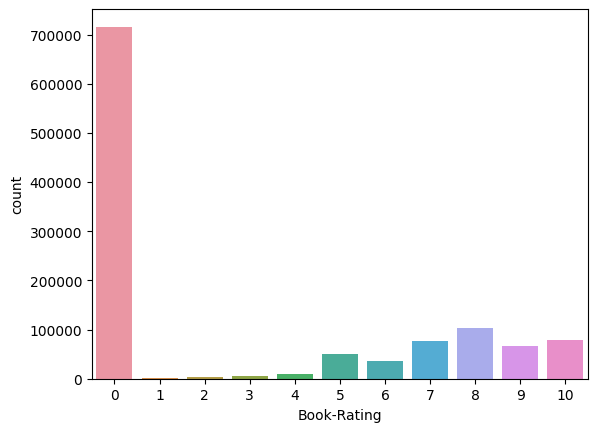

In [9]:
sns.countplot(x =ratings["Book-Rating"])

### Data Preprocessing -> Data Generation

In [3]:
ratings_filtered = ratings.loc[ratings["Book-Rating"] >= 8]
#sns.countplot(x =ratings_filtered["Book-Rating"])
ratings_filtered = ratings_filtered.loc[ratings_filtered['ISBN'].isin(books['ISBN'].unique()) & ratings_filtered['User-ID'].isin(users['User-ID'].unique())]

In [4]:
# Mappings
mapping_user = { user_id: index for index, user_id in enumerate(ratings_filtered["User-ID"].unique())}
mapping_item = { isbn_id: index for index, isbn_id in enumerate(ratings_filtered["ISBN"].unique())}

In [5]:
df_mapping_user = pd.DataFrame()
df_mapping_user["user_id"] = mapping_user.keys()
df_mapping_user["user_id_mapped"] = mapping_user.values()

df_mapping_item = pd.DataFrame()
df_mapping_item["isbn_id"] = mapping_item.keys()
df_mapping_item["isbn_id_mapped"] = mapping_item.values()

print(f'df_mapping_user: ')
print(f'{df_mapping_user.head()}')
print("=="*10)
print(f'df_mapping_item: ')
print(f'{df_mapping_item.head()}')

df_mapping_user: 
   user_id  user_id_mapped
0   276747               0
1   276751               1
2   276754               2
3   276762               3
4   276772               4
df_mapping_item: 
      isbn_id  isbn_id_mapped
0  0060517794               0
1  0671537458               1
2  0679776818               2
3  3596218098               3
4  0684867621               4


In [6]:
ratings_filtered_m = ratings_filtered.merge(df_mapping_user, left_on = "User-ID", right_on="user_id", how = "left")
ratings_filtered_m = ratings_filtered_m.merge(df_mapping_item, left_on = "ISBN", right_on="isbn_id", how = "left")
ratings_filtered_m.head()

,User-ID,ISBN,Book-Rating,user_id,user_id_mapped,isbn_id,isbn_id_mapped
0,276747,0060517794,9,276747,0,0060517794,0
1,276747,0671537458,9,276747,0,0671537458,1
2,276747,0679776818,8,276747,0,0679776818,2
3,276751,3596218098,8,276751,1,3596218098,3
4,276754,0684867621,8,276754,2,0684867621,4


In [7]:
ratings_filtered_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223807 entries, 0 to 223806
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   User-ID         223807 non-null  int64 
 1   ISBN            223807 non-null  object
 2   Book-Rating     223807 non-null  int64 
 3   user_id         223807 non-null  int64 
 4   user_id_mapped  223807 non-null  int64 
 5   isbn_id         223807 non-null  object
 6   isbn_id_mapped  223807 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 12.0+ MB


In [8]:
grouped = ratings_filtered_m.groupby(["isbn_id"]).mean(numeric_only=True)
grouped = grouped.sort_values(['Book-Rating'], ascending=False)
grouped

,User-ID,Book-Rating,user_id,user_id_mapped,isbn_id_mapped
isbn_id,,,,,
9971400162,114865.0,10.0,114865.0,19984.0,57432.0
0001821326,201017.0,10.0,201017.0,34204.0,80786.0
0001374869,10067.0,10.0,10067.0,1999.0,6861.0
B0001I1KOG,148258.0,10.0,148258.0,25555.0,66369.0
0001360469,10067.0,10.0,10067.0,1999.0,6860.0
...,...,...,...,...,...
0679803726,93047.0,8.0,93047.0,16189.0,45604.0
075350426X,203456.0,8.0,203456.0,34585.0,81276.0
0753504545,236727.0,8.0,236727.0,40280.0,89131.0


In [9]:
df20_10 = grouped.loc[grouped["Book-Rating"] == 10]

df20_10_l = df20_10.isbn_id_mapped.values.astype(int)
df20_10_random = list(np.random.choice(df20_10_l, 20, replace = False))
print(df20_10_random)

[np.int64(88337), np.int64(32688), np.int64(53053), np.int64(27240), np.int64(76164), np.int64(62206), np.int64(33394), np.int64(73676), np.int64(59111), np.int64(69146), np.int64(34684), np.int64(72075), np.int64(90664), np.int64(97025), np.int64(82551), np.int64(81700), np.int64(56946), np.int64(39576), np.int64(62011), np.int64(60817)]


In [10]:
grouped.to_csv("ISBNS_grouped.csv")
grouped


,User-ID,Book-Rating,user_id,user_id_mapped,isbn_id_mapped
isbn_id,,,,,
9971400162,114865.0,10.0,114865.0,19984.0,57432.0
0001821326,201017.0,10.0,201017.0,34204.0,80786.0
0001374869,10067.0,10.0,10067.0,1999.0,6861.0
B0001I1KOG,148258.0,10.0,148258.0,25555.0,66369.0
0001360469,10067.0,10.0,10067.0,1999.0,6860.0
...,...,...,...,...,...
0679803726,93047.0,8.0,93047.0,16189.0,45604.0
075350426X,203456.0,8.0,203456.0,34585.0,81276.0
0753504545,236727.0,8.0,236727.0,40280.0,89131.0


In [22]:
def clear_list(own, updated_list): 
    for o in own:
        for d in updated_list:
            if o == d:
                updated_list.remove(o)
    return updated_list

def alg_isbn(choice_l):
    
    
    df20_10 = grouped.loc[grouped["Book-Rating"] >= 9].isbn_id_mapped.values.astype(int)
    df20_10_random = list(np.random.choice(df20_10, 50, replace = False))
    
    df20_10_random = clear_list(choice_l,df20_10_random)
    
    
    recom_list = df20_10_random 
    return recom_list

alg_isbn()

TypeError: alg_isbn() missing 1 required positional argument: 'choice_l'

In [16]:
print(grouped.index.values[:5])
print(grouped.iloc[[0,1,2,3,4]])
print(grouped.loc[grouped.index.values[:5]].index.values)

['1852278943' '1550224751' '0345383486' '0345383370' '034538332X']
             User-ID  Book-Rating   user_id  user_id_mapped  isbn_id_mapped
isbn_id                                                                    
1852278943  197659.0         10.0  197659.0         33675.0         80205.0
1550224751   36907.0         10.0   36907.0          6676.0         23461.0
0345383486  250962.0         10.0  250962.0         42813.0         93217.0
0345383370   31826.0         10.0   31826.0          5770.0         20845.0
034538332X  164581.0         10.0  164581.0         28166.0         71173.0
['1852278943' '1550224751' '0345383486' '0345383370' '034538332X']


C:\Users\morit\AppData\Local\Temp\ipykernel_25260\1329451585.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grouped["Book-Rating"])


<Axes: xlabel='Book-Rating', ylabel='Density'>

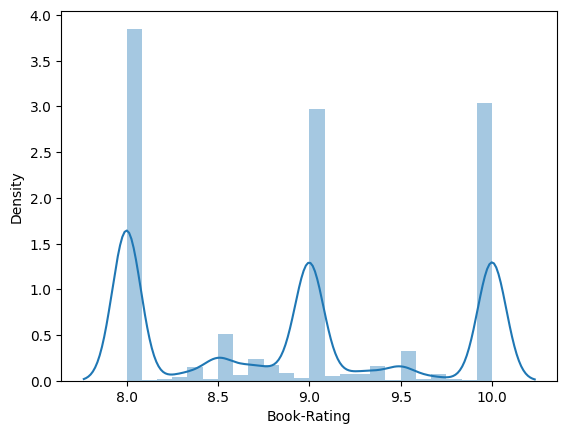

In [17]:
sns.distplot(grouped["Book-Rating"])

In [11]:
# edge_index_user_to_isbn
edge_index_user_to_isbn = ratings_filtered_m[["user_id_mapped", "isbn_id_mapped"]]
edge_index_user_to_isbn_user = torch.from_numpy(edge_index_user_to_isbn.user_id_mapped.values)
edge_index_user_to_isbn_isbn =torch.from_numpy( edge_index_user_to_isbn.isbn_id_mapped.values)
edge_index_user_to_isbn_user
edge_index_user_to_isbn_isbn

edge_index_user_to_isbn = torch.stack([edge_index_user_to_isbn_user, edge_index_user_to_isbn_isbn], dim=0)

In [19]:
edge_index_user_to_isbn

tensor([[    0,     0,     0,  ..., 47071, 47072, 47073],
        [    0,     1,     2,  ..., 98416, 12023, 79963]])

In [12]:
book_x = books[["ISBN", "Year-Of-Publication", "Publisher"]]
book_x = book_x[(book_x["ISBN"].isin(list(ratings_filtered_m.isbn_id.unique())) )]
#ratings_filtered_m.isbn_id.unique()

print(len(book_x["ISBN"].values))
print(len(ratings_filtered_m.isbn_id.unique()))

#df_mapping_item, left_on = "ISBN", right_on="isbn_id", how = "left"
book_x = book_x.merge(df_mapping_item,left_on =  "ISBN",right_on = "isbn_id", how= "left")
book_x = book_x.sort_values(by=['isbn_id_mapped'])

book_x = book_x.set_index('isbn_id_mapped')
book_x = book_x[["Year-Of-Publication", "Publisher"]]

print(book_x.info())

for c in [ "Year-Of-Publication", "Publisher"]:
    
    print(f'--- {c} {book_x[c].nunique()}')
    
book_x = pd.get_dummies(book_x, columns=["Publisher"], prefix=["publisher"])
book_x.replace({True:1, False:0}, inplace=True)
book_x["Year-Of-Publication"]= book_x["Year-Of-Publication"].astype(int)


display(book_x.head(2))


print("After Transformation")
print(book_x.info())


98417
98417
<class 'pandas.core.frame.DataFrame'>
Index: 98417 entries, 0 to 98416
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year-Of-Publication  98417 non-null  object
 1   Publisher            98415 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB
None
--- Year-Of-Publication 166
--- Publisher 8750


C:\Users\morit\AppData\Local\Temp\ipykernel_43740\2122506642.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  book_x.replace({True:1, False:0}, inplace=True)


,Year-Of-Publication,publisher_ Editions P. Terrail,publisher_'K' Pub,publisher_10-18,publisher_10/18,publisher_10/18 UGE,publisher_1001 nuits,"publisher_101 Productions; [distributed by Scribner, New York]","publisher_101 Productions; distributed by Scribner, New York",publisher_1stBooks Library,...,publisher_scholastic,publisher_shelterpetsink,publisher_t-2,publisher_toExcel,publisher_trade distribution by Simon and Schuster,publisher_Ã?ditions Michalon,publisher_Ã?ditions de Minuit,publisher_Ã?ditions de minuit,publisher_Ã?ditions du Seuil,publisher_Ã?lbaum
isbn_id_mapped,,,,,,,,,,,,,,,,,,,,,
0,2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After Transformation
<class 'pandas.core.frame.DataFrame'>
Index: 98417 entries, 0 to 98416
Columns: 8751 entries, Year-Of-Publication to publisher_Ã?lbaum
dtypes: int64(8751)
memory usage: 6.4 GB
None


In [ ]:
b

In [33]:
book_x.values

KeyboardInterrupt: 

In [13]:
torch_isbn = torch.tensor(book_x.values)
torch_isbn.shape


data = HeteroData()

data["user"].node_id = torch.from_numpy(ratings_filtered_m.user_id_mapped.unique())
data["isbn"].node_id =torch.from_numpy(ratings_filtered_m.isbn_id_mapped.unique())
data["isbn"].x = torch_isbn
data["user", "review", "isbn"].edge_index  = edge_index_user_to_isbn
data = T.ToUndirected()(data)
print(data)

HeteroData(
  user={ node_id=[47074] },
  isbn={
    node_id=[98417],
    x=[98417, 8751],
  },
  (user, review, isbn)={ edge_index=[2, 223807] },
  (isbn, rev_review, user)={ edge_index=[2, 223807] }
)


In [14]:
a = data.to_dict()
a

{'_global_store': {},
 'user': {'node_id': tensor([    0,     1,     2,  ..., 47071, 47072, 47073])},
 'isbn': {'node_id': tensor([    0,     1,     2,  ..., 98414, 98415, 98416]),
  'x': tensor([[2003,    0,    0,  ...,    0,    0,    0],
          [1995,    0,    0,  ...,    0,    0,    0],
          [1997,    0,    0,  ...,    0,    0,    0],
          ...,
          [1994,    0,    0,  ...,    0,    0,    0],
          [1995,    0,    0,  ...,    0,    0,    0],
          [2000,    0,    0,  ...,    0,    0,    0]])},
 ('user',
  'review',
  'isbn'): {'edge_index': tensor([[    0,     0,     0,  ..., 47071, 47072, 47073],
          [    0,     1,     2,  ..., 98416, 12023, 79963]])},
 ('isbn',
  'rev_review',
  'user'): {'edge_index': tensor([[    0,     1,     2,  ..., 98416, 12023, 79963],
          [    0,     0,     0,  ..., 47071, 47072, 47073]])}}

In [31]:
import pickle
with open('data_graph.pkl', 'wb') as fp:
    pickle.dump(a, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [15]:
with open('data_graph.pkl', 'rb') as fp:
    person = pickle.load(fp)
    print('Person dictionary')
    print(person)
b = HeteroData(person)

Person dictionary
{'user': {'node_id': tensor([    0,     1,     2,  ..., 47071, 47072, 47073])}, 'isbn': {'node_id': tensor([    0,     1,     2,  ..., 98414, 98415, 98416]), 'x': tensor([[2003,    0,    0,  ...,    0,    0,    0],
        [1995,    0,    0,  ...,    0,    0,    0],
        [1997,    0,    0,  ...,    0,    0,    0],
        ...,
        [1994,    0,    0,  ...,    0,    0,    0],
        [1995,    0,    0,  ...,    0,    0,    0],
        [2000,    0,    0,  ...,    0,    0,    0]], dtype=torch.int32)}, ('user', 'review', 'isbn'): {'edge_index': tensor([[    0,     0,     0,  ..., 47071, 47072, 47073],
        [    0,     1,     2,  ..., 98416, 12023, 79963]])}, ('isbn', 'rev_review', 'user'): {'edge_index': tensor([[    0,     1,     2,  ..., 98416, 12023, 79963],
        [    0,     0,     0,  ..., 47071, 47072, 47073]])}}


In [30]:
b = HeteroData(person)


HeteroData(
  user={ node_id=[47074] },
  isbn={
    node_id=[98417],
    x=[98417, 8751]
  },
  (user, review, isbn)={ edge_index=[2, 223807] },
  (isbn, rev_review, user)={ edge_index=[2, 223807] }
)

### Data Transformation -> Random Splitter + LinkLoader

In [16]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "review", "isbn"),
    rev_edge_types=("isbn", "rev_review", "user"), 
)
train_data, val_data, test_data = transform(data)

In [17]:
val_data["user", "review", "isbn"].edge_label.unique()

tensor([0., 1.])

In [18]:
train_data["user", "review", "isbn"].edge_index

tensor([[15497, 37391, 22908,  ..., 22900, 32329, 16468],
        [44465,   583, 35008,  ..., 62011, 78186, 46152]])

In [19]:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["user", "review", "isbn"].edge_label_index
edge_label = train_data["user", "review", "isbn"].edge_label


In [20]:
edge_label_index

tensor([[ 8078,  2852,  4491,  ..., 43260, 39891,  2481],
        [26731, 12416,   856,  ...,  4759,  4225, 11329]])

In [21]:
edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [22]:
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[5, 5],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "review", "isbn"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)
# Ich denke hier ist der Fehler
#train_data, val_data, test_data = transform(data)
val_loader = LinkNeighborLoader(
    
     data=val_data,
    num_neighbors=[5, 5],
    #neg_sampling_ratio=2.0,
    edge_label_index=(("user", "review", "isbn"), val_data["user", "review", "isbn"].edge_label_index),
    edge_label=val_data["user", "review", "isbn"].edge_label,
    batch_size=128,
    shuffle=True,
    )

test_loader = LinkNeighborLoader(
    
     data=test_data,
    num_neighbors=[5, 5],
    #neg_sampling_ratio=2.0,
    edge_label_index=(("user", "review", "isbn"), test_data["user", "review", "isbn"].edge_label_index),
    edge_label=test_data["user", "review", "isbn"].edge_label,
    batch_size=128,
    shuffle=True,
    )
#test_loader = LinkNeighborLoader(test_dataset, batch_size=32)

In [67]:
train_data

HeteroData(
  user={ node_id=[47074] },
  isbn={
    node_id=[98417],
    x=[98417, 8751]
  },
  (user, review, isbn)={
    edge_index=[2, 125333],
    edge_label=[53714],
    edge_label_index=[2, 53714]
  },
  (isbn, rev_review, user)={ edge_index=[2, 125333] }
)

In [23]:
sample_data = next(iter(train_loader))
sample_data

HeteroData(
  user={
    node_id=[2010],
    n_id=[2010],
    num_sampled_nodes=[3],
  },
  isbn={
    node_id=[2514],
    x=[2514, 8751],
    n_id=[2514],
    num_sampled_nodes=[3],
  },
  (user, review, isbn)={
    edge_index=[2, 2638],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[2638],
    num_sampled_edges=[2],
    input_id=[128],
  },
  (isbn, rev_review, user)={
    edge_index=[2, 2601],
    e_id=[2601],
    num_sampled_edges=[2],
  }
)

In [24]:
from torch_geometric.nn import to_hetero
import torch_geometric
#d = torch_geometric.utils.to_networkx(sample_data.to_homogeneous())
#nx.draw(d)


### Model Generation

In [25]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
import tqdm
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

Device: 'cpu'


In [39]:
data.metadata

<bound method HeteroData.metadata of HeteroData(
  user={ node_id=[47074] },
  isbn={
    node_id=[98417],
    x=[98417, 8751],
  },
  (user, review, isbn)={ edge_index=[2, 223807] },
  (isbn, rev_review, user)={ edge_index=[2, 223807] }
)>

In [26]:
class GNN(torch.nn.Module):
    # Important Q: Can I input only a small subgraph (GNN) and use this with a saved embedding of the movies (Classifier)?
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x, edge_index) :
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x #Embeddings for all the Books and Users
    
    
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module): #Nur das hier ist für die Edge_label_indexe
    def forward(self, x_user, x_movie, edge_label_index) :
        
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

In [27]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.movie_lin = torch.nn.Linear(8751, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)# hier müsste es mehr sein!
        self.movie_emb = torch.nn.Embedding(data["isbn"].num_nodes, hidden_channels)
        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
        
    def forward(self, data: HeteroData) :
    
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "isbn": self.movie_lin(data["isbn"].x.float()) + self.movie_emb(data["isbn"].node_id),
        } 
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["isbn"],
            data["user", "review", "isbn"].edge_label_index,
        )
        return pred
    
model = Model(hidden_channels=64)

t = data["isbn"].x[0]
m = torch.nn.Linear(8751, 64)
input = torch.randn(128, 8751)
output = m(t.float())
print(output.size())

input.shape

### Training and Validation

In [28]:


optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = BCEWithLogitsLoss()

def train():
    model.train()
    total_loss = total_examples = 0

    for sampled_data in tqdm.tqdm(train_loader):
        sampled_data.to(device)
        optimizer.zero_grad()
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "review", "isbn"].edge_label
        loss = criterion(pred, ground_truth)
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    #print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")
    return total_loss / total_examples


@torch.no_grad()
def test(loader):
    model.eval()
    y_pred, y_true = [], []
    
    for s_data in tqdm.tqdm(loader):
        
        s_data = s_data.to(device)
        out = model(s_data)
        y_pred.append(out)
        ground_truth = s_data["user", "review", "isbn"].edge_label
        y_true.append(ground_truth)
    auc = roc_auc_score(torch.cat(y_true), torch.cat(y_pred))
    ap = average_precision_score(torch.cat(y_true), torch.cat(y_pred))

    return auc, ap

In [29]:
for epoch in range(30):#30 epochen
    loss = train()
    
    if epoch % 5 == 0:
        val_auc, val_ap = test(val_loader)
        print(f'Epoch {epoch:>2} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

  0%|          | 0/420 [00:00<?, ?it/s]

100%|██████████| 525/525 [02:30<00:00,  3.50it/s]


Epoch  0 | Loss: 2.1353 | Val AUC: 0.5798 | Val AP: 0.3638


100%|██████████| 525/525 [01:35<00:00,  5.50it/s]


Epoch  5 | Loss: 0.5514 | Val AUC: 0.7475 | Val AP: 0.5820


100%|██████████| 525/525 [01:35<00:00,  5.51it/s]


Epoch 10 | Loss: 0.4598 | Val AUC: 0.8204 | Val AP: 0.7004


100%|██████████| 525/525 [01:36<00:00,  5.45it/s]


Epoch 15 | Loss: 0.4082 | Val AUC: 0.8540 | Val AP: 0.7585


100%|██████████| 525/525 [01:18<00:00,  6.66it/s]


Epoch 20 | Loss: 0.3743 | Val AUC: 0.8722 | Val AP: 0.7856


100%|██████████| 525/525 [01:17<00:00,  6.76it/s]


Epoch 25 | Loss: 0.3481 | Val AUC: 0.8749 | Val AP: 0.7904


100%|██████████| 420/420 [02:40<00:00,  2.61it/s]


In [30]:
val_auc, val_ap = test(val_loader)
print(f'Epoch {epoch:>2} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

100%|██████████| 525/525 [01:37<00:00,  5.39it/s]


Epoch 29 | Loss: 0.3299 | Val AUC: 0.8807 | Val AP: 0.8026


### Test Model

In [31]:
t_auc, t_ap = test(test_loader)
print(f' Val AUC: {t_auc:.4f} | Val AP: {t_ap:.4f}')

100%|██████████| 525/525 [01:40<00:00,  5.24it/s]

 Val AUC: 0.8723 | Val AP: 0.7713


Val AUC: 0.8724 | Val AP: 0.7822

### Safe Model

In [36]:
PATH = "C:/Users/morit/Documents/Python Scripts/Graph/Book_Crossing/model/model_torch.pt"
torch.save(model.state_dict(), PATH)

In [37]:
model = Model(hidden_channels=64)
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()

Model(
  (movie_lin): Linear(in_features=8751, out_features=64, bias=True)
  (user_emb): Embedding(47074, 64)
  (movie_emb): Embedding(98417, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__review__isbn): SAGEConv(64, 64, aggr=mean)
      (isbn__rev_review__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__review__isbn): SAGEConv(64, 64, aggr=mean)
      (isbn__rev_review__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)

In [33]:
import pickle
filename = 'sage_final_book_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [433]:
import dill as pickle
filename = 'final_book_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [434]:
gnn_loaded = pickle.load(open(filename, "rb"))

In [435]:
gnn_loaded

Model(
  (movie_lin): Linear(in_features=8751, out_features=64, bias=True)
  (user_emb): Embedding(47074, 64)
  (movie_emb): Embedding(98417, 64)
  (gnn): GraphModule(
    (conv1): Module(
      (user__review__isbn): SAGEConv(64, 64, aggr=mean)
      (isbn__rev_review__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): Module(
      (user__review__isbn): SAGEConv(64, 64, aggr=mean)
      (isbn__rev_review__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)

# Preprocessing

In [104]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [105]:
df = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1') 
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1') 
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', error_bad_lines=False) 

C:\Users\morit\AppData\Local\Temp\ipykernel_50592\862360678.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', error_bad_lines=False)
Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9

Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10

In [26]:
# Preprocessing
df = df.loc[df['ISBN'].isin(books['ISBN'].unique()) & df['User-ID'].isin(users['User-ID'].unique())]

# Keep the 100k highest ratings
df = df[df['Book-Rating'] >= 8].iloc[:100000]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 16 to 472768
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      100000 non-null  int64 
 1   ISBN         100000 non-null  object
 2   Book-Rating  100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.1+ MB


In [103]:
# Create mappings
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

NameError: name 'df' is not defined

In [32]:
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

In [33]:
user_ids

tensor([    0,     0,     0,  ..., 19693, 19693, 19693])

In [34]:
item_ids

tensor([    0,     1,     2,  ..., 56947, 29455, 48816])

In [35]:
edge_index

tensor([[    0,     0,     0,  ..., 19693, 19693, 19693],
        [    0,     1,     2,  ..., 56947, 29455, 48816]])

In [36]:
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

print(len(train_edge_index))
print(len(val_edge_index))
print(len(test_edge_index))

2
2
2


In [37]:
print(train_edge_index)
print(val_edge_index)
print(test_edge_index)

tensor([[ 2266, 15290,  6142,  ...,  8835,  9112, 14149],
        [ 8504,  1578,   413,  ...,  3416, 28598,  5062]])
tensor([[14501,  4209, 12333,  ..., 19004, 19462, 12070],
        [42010,   726, 24062,  ...,   888, 56555,   797]])
tensor([[ 4287, 17755, 14746,  ...,  8235, 19323,  9009],
        [16526, 53466, 42473,  ..., 26916,   433, 15879]])


In [38]:
def sample_mini_batch(edge_index):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)
    
    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]
    
    return user_index, pos_item_index, neg_item_index

# Solution Try

## Data

In [ ]:
movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'

# Load the entire movie data frame into memory:
movies_df = pd.read_csv(movies_path, index_col='movieId')

# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())
# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (9742, 20)  # 20 genres in total.

# Load the entire ratings data frame into memory:
ratings_df = pd.read_csv(ratings_path)

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())
# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)
# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)
print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)


data = HeteroData()
# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))
# Add the node features and edge indices:
data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie
data = T.ToUndirected()(data)


transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"), 
)
train_data, val_data, test_data = transform(data)

## LinkNeighborLoader

In [ ]:
# Define seed edges:
from torch_geometric.loader import LinkNeighborLoader
edge_label_index = train_data["user", "rates", "movie"].edge_label_index
edge_label = train_data["user", "rates", "movie"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Define the validation seed edges:
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), val_data["user", "rates", "movie"].edge_label_index),
    edge_label=val_data["user", "rates", "movie"].edge_label,
    batch_size=3 * 128,
    shuffle=False,
)
sampled_data = next(iter(val_loader))

## Model

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )
        return pred
        
model = Model(hidden_channels=64)

## Train

In [ ]:
import tqdm
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

## Evaluate

In [ ]:

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")

# Implementing the LightGCN Architecture

In [39]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

In [40]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss

def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1
    
    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.
    
    return np.mean(ndcg)

In [41]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

In [42]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

In [45]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
%%time

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(31):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)
        
        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}:   {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

Epoch 0 | Train loss: -0.69336 | Val loss: -0.69256 | Val recall@20:   0.00792 | Val ndcg@20: 0.00421
Epoch 5 | Train loss: -0.72708 | Val loss: -0.63786 | Val recall@20:   0.01772 | Val ndcg@20: 0.00826
Epoch 10 | Train loss: -0.91278 | Val loss: -0.43344 | Val recall@20:   0.01884 | Val ndcg@20: 0.00849
Epoch 15 | Train loss: -1.43524 | Val loss: -0.04398 | Val recall@20:   0.01811 | Val ndcg@20: 0.00825
Epoch 20 | Train loss: -2.29949 | Val loss: 0.49414 | Val recall@20:   0.01785 | Val ndcg@20: 0.00863
Epoch 25 | Train loss: -3.03163 | Val loss: 1.15763 | Val recall@20:   0.01806 | Val ndcg@20: 0.00874
Epoch 30 | Train loss: -4.14914 | Val loss: 1.92553 | Val recall@20:   0.01790 | Val ndcg@20: 0.00844
CPU times: total: 30min 33s
Wall time: 17min 37s


In [47]:
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])

print(f"Test loss: {test_loss:.5f} | Test recall@{K}: {test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")

Test loss: 1.90032 | Test recall@20: 0.01746 | Test ndcg@20: 0.00883


In [48]:
model.emb_items.weight

Parameter containing:
tensor([[-0.8027,  0.8152, -0.8104,  ...,  0.8056,  0.8098,  0.8037],
        [-0.1424,  0.1563, -0.1528,  ...,  0.1592,  0.1581,  0.1516],
        [-0.6368,  0.6401, -0.6392,  ...,  0.6308,  0.6432,  0.6407],
        ...,
        [ 0.2991, -0.2995,  0.3002,  ..., -0.2973, -0.2941, -0.3004],
        [ 0.1893, -0.1920,  0.1926,  ..., -0.1899, -0.1826, -0.1895],
        [ 0.1952, -0.1906,  0.1941,  ..., -0.1976, -0.1972, -0.2010]],
       requires_grad=True)

In [49]:
model.emb_users.weight

Parameter containing:
tensor([[-0.4302,  0.4406, -0.4240,  ...,  0.4398,  0.4345,  0.4292],
        [ 0.0005,  0.0054, -0.0134,  ...,  0.0094,  0.0159, -0.0085],
        [-0.4479,  0.4440, -0.4700,  ...,  0.4619,  0.4506,  0.4574],
        ...,
        [ 0.1863, -0.1836,  0.1860,  ..., -0.1870, -0.1816, -0.1868],
        [ 0.0127,  0.0027,  0.0062,  ...,  0.0010,  0.0069, -0.0064],
        [-0.2211,  0.2245, -0.2211,  ...,  0.2216,  0.2291,  0.2158]],
       requires_grad=True)